## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random
#random.seed(0)
#np.random.seed(0)
#torch.manual_seed(0)

plt.ion()   # interactive mode
import imageio
import os




folderlocation = './data/'
os.mkdir(folderlocation)
folderlocation = './data/STL10/'
os.mkdir(folderlocation)
path = folderlocation
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'train/'
if not os.path.exists(path):
    os.mkdir(path)
        
path = folderlocation + 'valid/'
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'test/'
if not os.path.exists(path):
    os.mkdir(path)
    
for iter1 in range(10):    # 10 = number of classes
    path = folderlocation + 'train/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    path = folderlocation + 'valid/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    
    path = folderlocation + 'test/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)

        
data_train = torchvision.datasets.STL10('/files/', split='train', download=True,
                             transform=torchvision.transforms.Compose([
                             ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x)
    
data_test = torchvision.datasets.STL10('/files/', split='test', download=True,
                             transform=torchvision.transforms.Compose([
                             ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)



  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /files/stl10_binary.tar.gz to /files/
Files already downloaded and verified


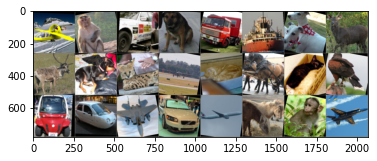

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((272,272)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None): 
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#import matplotlib.pyplot as plt
#plt.rcParams["figure.dpi"] = 200

#plt.savefig('Transformed.pdf')  

imshow(out)#, title=[class_names[x] for x in classes])

In [3]:
# model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

Num_class=10

# Customizable SpinalNet Shared Weight Model.
class SpinalNet(nn.Module):
    def __init__(self, Input_Size, Number_of_Split, HL_width, number_HL, Output_Size, Activation_Function):
        
        super(SpinalNet, self).__init__()
        Splitted_Input_Size = int(np.round(Input_Size/Number_of_Split))
        self.lru = Activation_Function
        self.fc1 = nn.Linear(Splitted_Input_Size, HL_width)
        if number_HL>1:
            self.fc2 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        
        
        self.fcx = nn.Linear(HL_width*number_HL, Output_Size)

    def forward(self, x):
        x_all =x        
        
        Splitted_Input_Size = self.fc1.in_features
        HL_width = self.fc2.in_features - self.fc1.in_features
        number_HL = int(np.round(self.fcx.in_features/HL_width))
        length_x_all = number_HL*Splitted_Input_Size      
        
        while x_all.size(dim=1) < length_x_all:
            x_all = torch.cat([x_all, x],dim=1)
            
        x = self.lru(self.fc1(x_all[:,0:Splitted_Input_Size]))
        x_out = x
        
        for counter1 in range(1, number_HL):

            if number_HL>counter1:
                x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
                x = self.lru(self.fc2(torch.cat([x_from_all, x], dim=1)))
                x_out = torch.cat([x_out, x], dim=1)
        x = self.fcx(x_out)
        return x

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [5]:
'''
Changing the fully connected layer to SpinalNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.fc = SpinalNet(Input_Size = num_ftrs, Number_of_Split =8, HL_width=20, number_HL=8, Output_Size=Num_class, Activation_Function = nn.ReLU(inplace=True))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.9287 Acc: 0.5156
valid Loss: 0.9863 Acc: 0.8860
test Loss: 0.9642 Acc: 0.9106

Epoch 1/4
----------
train Loss: 0.5046 Acc: 0.9180
valid Loss: 0.1701 Acc: 0.9580
test Loss: 0.1462 Acc: 0.9730

Epoch 2/4
----------
train Loss: 0.1733 Acc: 0.9596
valid Loss: 0.1044 Acc: 0.9720
test Loss: 0.0885 Acc: 0.9793

Epoch 3/4
----------
train Loss: 0.1026 Acc: 0.9744
valid Loss: 0.0869 Acc: 0.9760
test Loss: 0.0721 Acc: 0.9805

Epoch 4/4
----------
train Loss: 0.0735 Acc: 0.9809
valid Loss: 0.0820 Acc: 0.9720

Training complete in 16m 38s
Best val Acc: 0.976000


In [6]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0848 Acc: 0.9782
valid Loss: 0.0827 Acc: 0.9820
test Loss: 0.0658 Acc: 0.9833

Epoch 1/9
----------
train Loss: 0.0679 Acc: 0.9842
valid Loss: 0.0743 Acc: 0.9860
test Loss: 0.0590 Acc: 0.9845

Epoch 2/9
----------
train Loss: 0.0567 Acc: 0.9871
valid Loss: 0.0768 Acc: 0.9840

Epoch 3/9
----------
train Loss: 0.0501 Acc: 0.9904
valid Loss: 0.0729 Acc: 0.9820

Epoch 4/9
----------
train Loss: 0.0614 Acc: 0.9858
valid Loss: 0.0748 Acc: 0.9780

Epoch 5/9
----------
train Loss: 0.0545 Acc: 0.9896
valid Loss: 0.0762 Acc: 0.9800

Epoch 6/9
----------
train Loss: 0.0493 Acc: 0.9889
valid Loss: 0.0707 Acc: 0.9800

Epoch 7/9
----------
train Loss: 0.0524 Acc: 0.9891
valid Loss: 0.0747 Acc: 0.9800

Epoch 8/9
----------
train Loss: 0.0482 Acc: 0.9898
valid Loss: 0.0712 Acc: 0.9800

Epoch 9/9
----------
train Loss: 0.0444 Acc: 0.9902
valid Loss: 0.0717 Acc: 0.9780

Training complete in 24m 37s
Best val Acc: 0.986000


# Delete Downloaded Data

In [7]:
import shutil
shutil.rmtree('./data/')